In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
def fa(x=1,y=1,**kwargs):
    fig,ax = plt.subplots(x,y,**kwargs)
    return fig,ax
%matplotlib notebook
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers

from tqdm import tqdm
import time
import collections
import pandas as pd

def plot_dataset(x,y,**kwargs):
    plt.scatter(x,y,alpha=0.3,marker='.',**kwargs)


# Nomenclature Clarification


- Logit Transformation transforms probabilities (bounded between [0,1]) to [-Inf, +Inf]. This is a vertically standing sigmoid if you will. 
- In tensorflow the output of this conversion is called logits (super confusing).
- Softargmax takes a bunch of logits and generates a new vector that sums to 1, thus it create a p.d out of these numbers.
- Squashing the range [-Inf,+Inf] to a bounded range is done with a Sigmoid function and it is the inverse operation of Logit Transform. 

# Sigmoid function (aka Logistic function)
The general form of a sigmoid function is as follows
$$ p(x) = \frac{1}{1 + e^{-x}}$$
This is equivalent to 
$$ p(x) = \frac{e^x}{e^x + 1}$$

What this function does is to take the ratio of 1 to $1+e^{-x}$. 

At zero, the denominator is 2 ($e^0 = 1$), therefore we have 1/(1+1) and the sigmoid is equal to 0.5 at x = 0. 

When $x$ goes to plus infinity, the exponential term goes to zero, hence denominator becomes more and more equal to nominator $\frac{1}{1+smallnumber}$, asymptoting at 1. 

When $x$ goes to minus infinity, the denominator grows hence the ratio approaches to 0.

The equivalent formulation is easier to grasp. The contribution of the plus 1 terms gets smaller and smaller with increasing x.

In logistic regression, we generally have a linear function in the exponent, in the form $w_0 + w_1X + ...$. In this case, if the slope parameters are 0, we obtain a horizontal line, whereas the strength of the slope determines the steepness of the sigmoid. And when the intercept is 0, the sigmoid equals 0.5 at point 0. The intercept therefore shifts the sigmoid left and right.

<IPython.core.display.Javascript object>


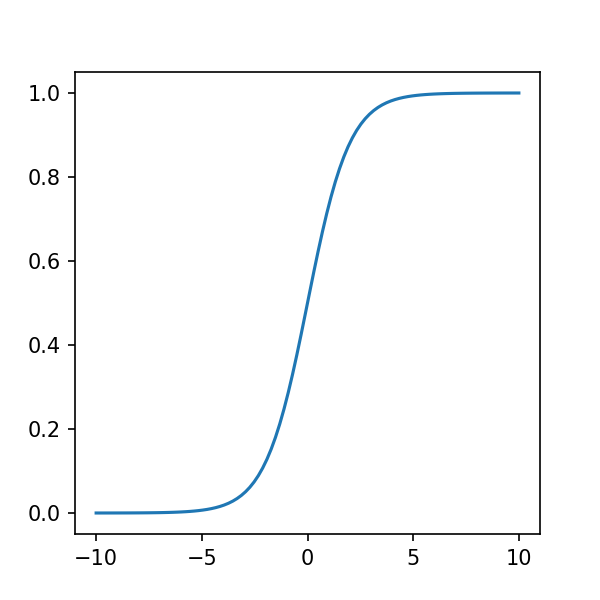

In [5]:
## Sigmoid
def sigm(x):
    return 1. / (1. + np.exp(-x))
x = np.linspace(-10.,10.,100)    
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x,sigm(np.array(x)))

# Logit transformation

This is a transformation applied to probabilities, so numbers with the range of 0 and 1. After this transformation we obtain odds which are not anymore bounded between 0 and 1.

$$logit(p) = log(\frac{p}{1-p}) $$

This is this transformed values that the logistic regression tries to model.

$$logit(p) = w^TX$$

which is equal to 

$$log(\frac{p}{1-p}) = w^TX$$

or without the matrix notation

$$log(\frac{p}{1-p}) = w_0 + w_1X$$

we can recover the odds by exponentiating

$$\frac{p}{1-p} = e^{w_0 + w_1X}$$

and the predicted probability $p$ would be equal to

$$ p = \frac{1}{1+e^{-(w_0 + w_1X)}} = \frac{e^{w_0 + w_1X}}{e^{w_0 + w_1X}+1}$$

which is exactly the sigmoid (logistic) function. Note how formulating everything in terms of logits make it easier to grasp the overall idea.

The more the term $wX$ at the exponent grows towards infinity the closer we approach the upper asymptote, and vice versa.

<IPython.core.display.Javascript object>


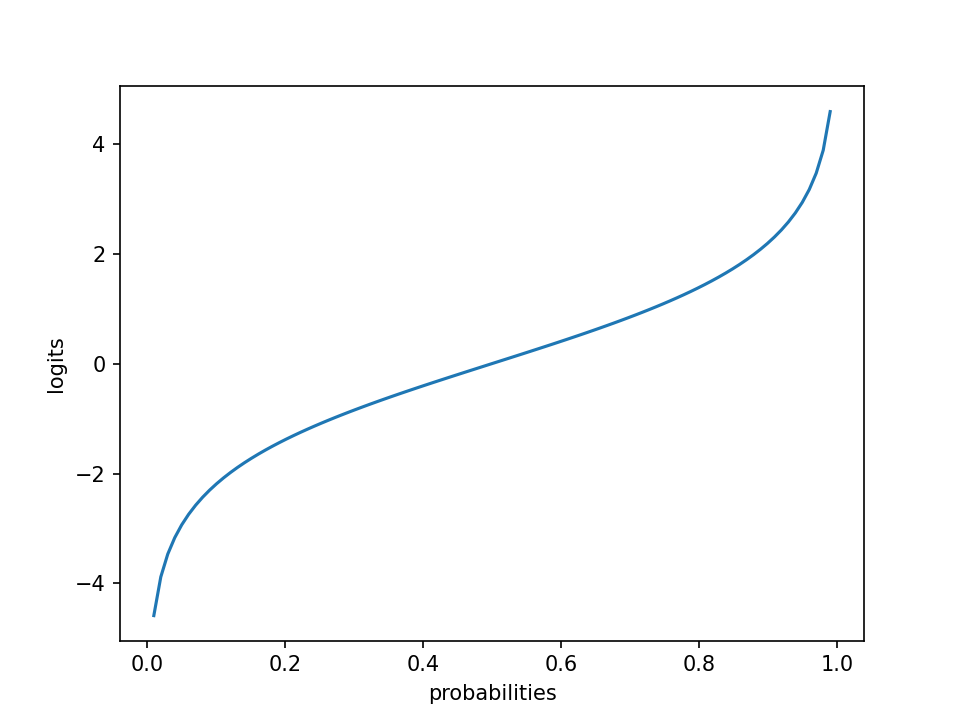

/var/folders/04/n4mfbs5j2dj4kpmdzny48d0h0000gn/T/ipykernel_50553/2311582547.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(p/(1-p))
/var/folders/04/n4mfbs5j2dj4kpmdzny48d0h0000gn/T/ipykernel_50553/2311582547.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(p/(1-p))


Text(0, 0.5, 'logits')

In [26]:
def logit_transform(p):
    return np.log(p/(1-p))

f,a = fa()
p = np.linspace(0,1,100)
a.plot(p,logit_transform(p))
a.set_xlabel('probabilities')
a.set_ylabel('logits')

# Logistic Regression

Logistic regression is a linear regression applied on logit transformed probabilities. 

$$ p(y | x, w)$$ which is $$ Bernouilli(y | sigmoid(w^Tx)) $$

For example one can model the probability of having at least one trafic accident in relation to average speed of driving. For each person, one could have a binary variable (accident or not) to be predicted by a continous number (speed).

The negative log-likelihood function on parameters runs through all data points

$$ L(w) = \sum_i^N{\log[ p_i^{y_{i}} \times (1-p_i)^{(1-y_{i})} ]} $$

In this equation above,
- predicted values are probabilities, $p_i$, and
- target values are $y_i$ which play the role of indicator variable. 

It is either class 1 or 0 which is the true class.

This can also be written in the following form without loss of generality:

$$ L(w) = \sum{y_i\log(p_i)} = y_i \log{p_i} + (1-y_i) \log{1-p_i} $$

This similarity of this loss function to Cross-Entropy is now clearer.





<IPython.core.display.Javascript object>


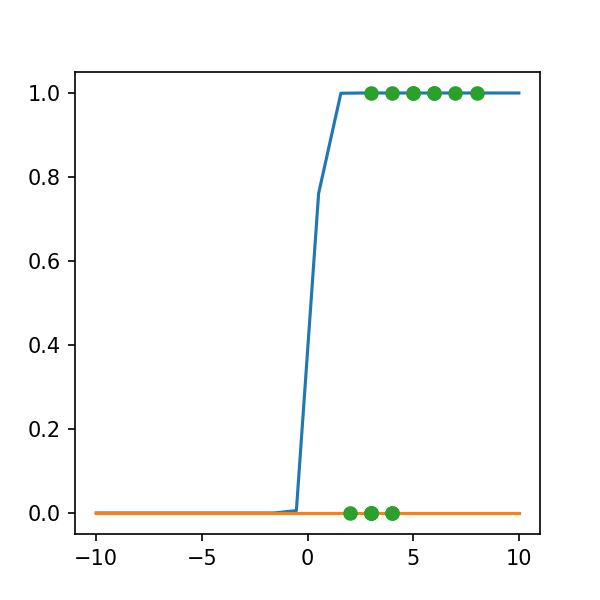

[[  0.   0.   0.  nan]
 [  0.   0.   0.  nan]
 [  0.   0.   0.  nan]
 [  0.   0.   0.  nan]
 [  0.   0.   0.  nan]
 [  0.   0.   0.  nan]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]
 [  1.   0.   0. -inf]]
loss:
-inf
[[  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.

/var/folders/04/n4mfbs5j2dj4kpmdzny48d0h0000gn/T/ipykernel_50553/265899165.py:17: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))
/var/folders/04/n4mfbs5j2dj4kpmdzny48d0h0000gn/T/ipykernel_50553/265899165.py:34: RuntimeWarning: divide by zero encountered in log10
  second_sum  = y     * np.log10(y_hat)
/var/folders/04/n4mfbs5j2dj4kpmdzny48d0h0000gn/T/ipykernel_50553/265899165.py:34: RuntimeWarning: invalid value encountered in multiply
  second_sum  = y     * np.log10(y_hat)


-125.22847819621617

In [6]:
#this is how you define machine epsilon with python
EPSILON = np.finfo(float).eps
#example
np.set_printoptions(suppress=True)
#data
x = np.array([3,4,3,2,4,3,5,4,6,7,8,6,5,3,]) # x values
y = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,1,]) # labels
#
w = np.array([-2500.,6])                     # the model parameters bad example
w2 = np.array([-2.,6])                     # the model parameters reasonable example
X = np.c_[np.ones(x.shape[0]),x]             # Design matrix
C = np.ones(20)                              # Constant
x_axis = np.linspace(-10,10,20)                # 
x_axis = np.c_[C,x_axis]

def logistic(x):
    return 1. / (1. + np.exp(-x))

def cross_entropy_robust(w,verbose=True):
    EPSILON    = np.finfo(float).eps
    y_hat      = logistic(X @ w)
    first_sum = (1-y) * np.log10(1-y_hat+EPSILON)
    second_sum  = y * np.log10(y_hat+EPSILON)
    loss       = np.sum(first_sum[y == 0]) + np.sum(second_sum[y == 1])
    if verbose:
        print(np.c_[y,y_hat,first_sum,second_sum])
        print('loss:')
        print(loss)
    return loss

def cross_entropy(w,verbose=True):
    y_hat = logistic(X @ w)
    first_sum   = (1-y) * np.log10(1-y_hat)
    second_sum  = y     * np.log10(y_hat)
    loss = np.sum(first_sum[y == 0]) + np.sum(second_sum[y == 1])
    if verbose:
        print(np.c_[ y , y_hat , first_sum , second_sum])
        print('loss:')
        print(loss)
    return loss

fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_axis[:,1],logistic(x_axis @ w2))
ax.plot(x_axis[:,1],logistic(x_axis @ w))
ax.plot(x,y,'o')
cross_entropy(w)
cross_entropy_robust(w)

The aim is to find the w vector that maximizes the cross_entropy.
if your starting values are totally off (try to put in w values that are super wrong), 
one might easily end up with problems:
- -Inf problem, because logistic function returns 0 and log(0) is -Inf. 
- And the Nan problem, which is actually caused by -Inf * 0, returning NaN.

In [12]:
#show the error surface
GS = 100 # grid size
L = np.zeros((GS,GS))
params = np.linspace(-50,50,GS)
for i,B0 in enumerate(params):
    for j,B1 in enumerate(params):
        w = np.array([B0,B1])
        L[i,j] =  cross_entropy_robust(w,verbose=True)
L        

[[  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]
 [  1.           0.           0.         -15.65355977]]
loss:
-125.22847819621617
[[  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.          -0.        ]
 [  0.           0.           0.      

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array([[-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865],
       [-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865],
       [-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865],
       ...,
       [-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865],
       [-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865],
       [-125.2284782 , -125.2284782 , -125.2284782 , ...,  -93.92135865,
         -93.92135865,  -93.92135865]])

In [20]:
x_axis @ [1, 1]

array([-9.        , -7.94736842, -6.89473684, -5.84210526, -4.78947368,
       -3.73684211, -2.68421053, -1.63157895, -0.57894737,  0.47368421,
        1.52631579,  2.57894737,  3.63157895,  4.68421053,  5.73684211,
        6.78947368,  7.84210526,  8.89473684,  9.94736842, 11.        ])

<IPython.core.display.Javascript object>


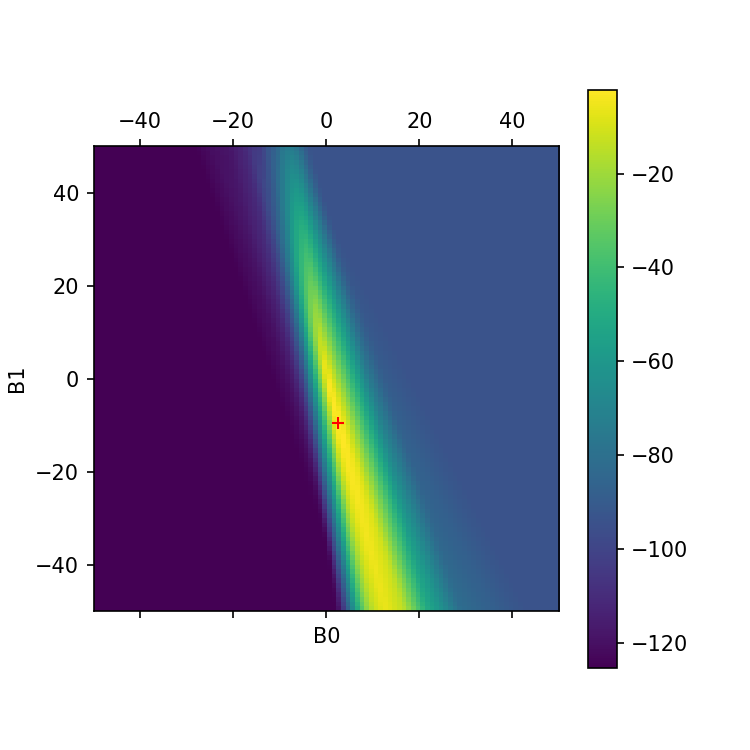

<IPython.core.display.Javascript object>


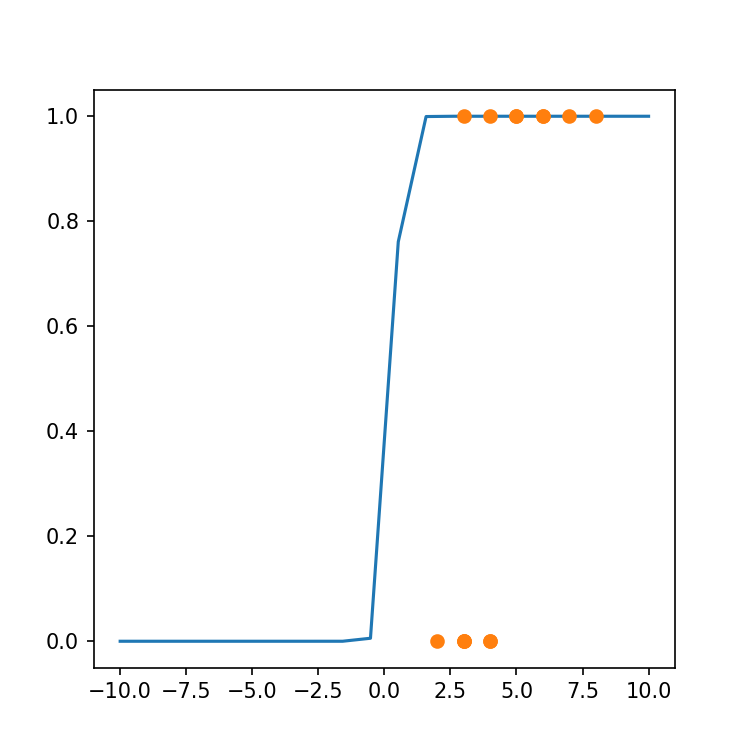

In [23]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
img = ax.matshow(L,extent=[np.min(params),np.max(params),np.min(params),np.max(params)],origin='lower')
yi,xi = np.unravel_index(np.argmax(L),L.shape)
ax.plot(params[xi],params[yi],'r+')
ax.set_xlabel('B0')
ax.set_ylabel('B1')
plt.colorbar(img,ax=ax)

w = params[xi],params[yi]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x_axis[:,1],logistic(x_axis @ w2))
ax.plot(x,y,'o')


<IPython.core.display.Javascript object>


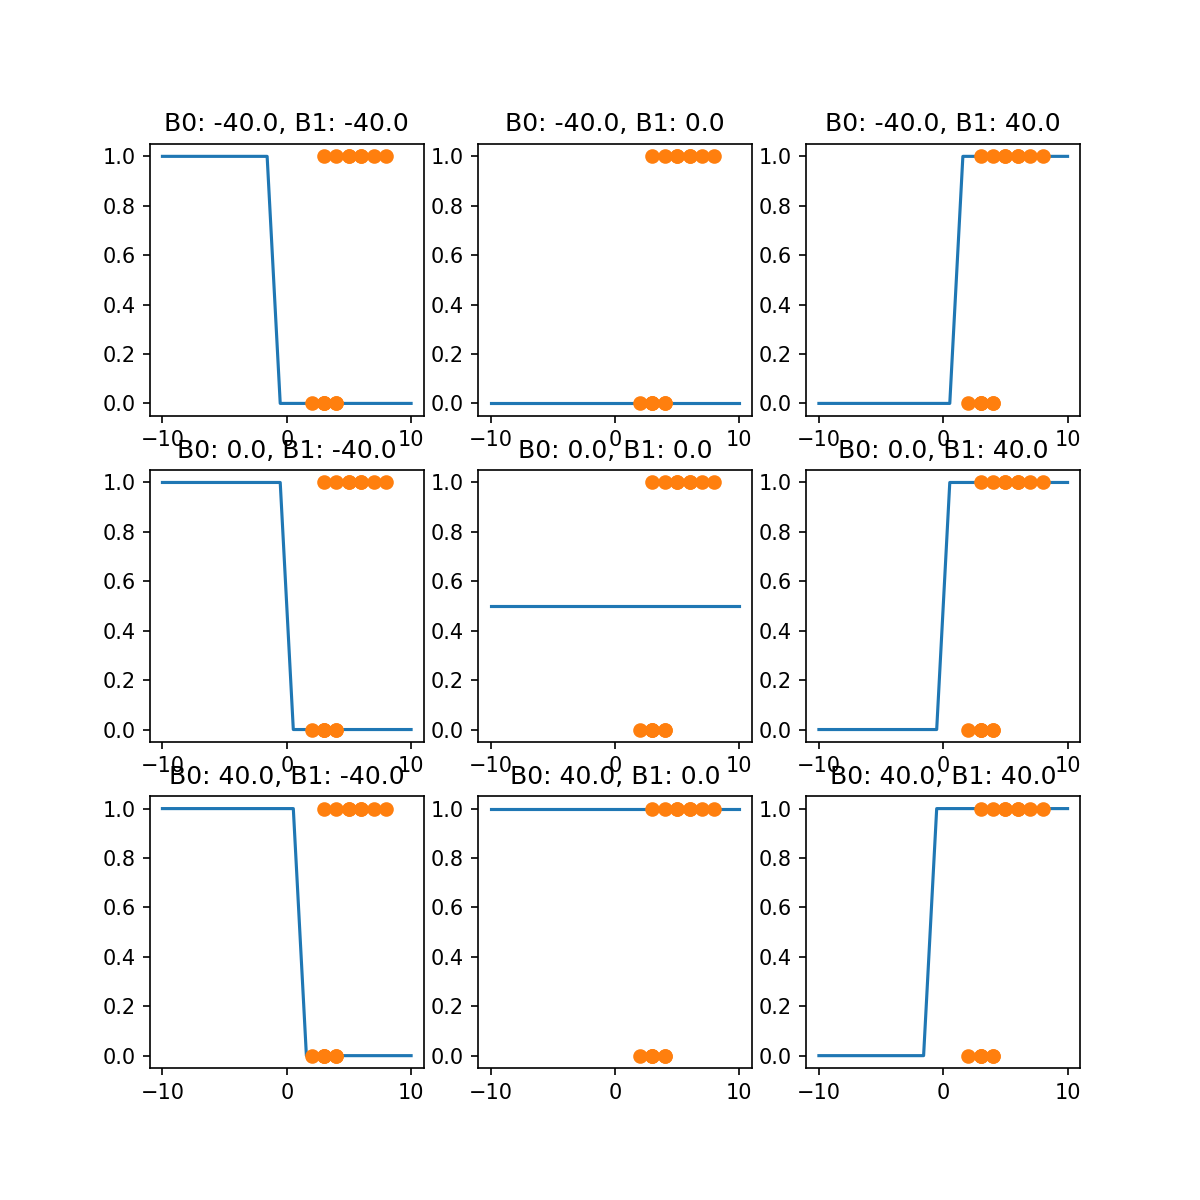

In [24]:
GS = 3 # grid size
fig,ax = plt.subplots(GS,GS,figsize=(8,8))
L = np.zeros((GS,GS))
params = np.linspace(-40,40,GS)
for i,B0 in enumerate(params):
    for j,B1 in enumerate(params):
        w = np.array([B0,B1])
        ax[i,j].plot(x_axis[:,1],logistic(x_axis @ w))
        ax[i,j].set_title(f"B0: {B0}, B1: {B1}")
        ax[i,j].plot(x,y,'o')


# 2D Sigmoid function

<IPython.core.display.Javascript object>


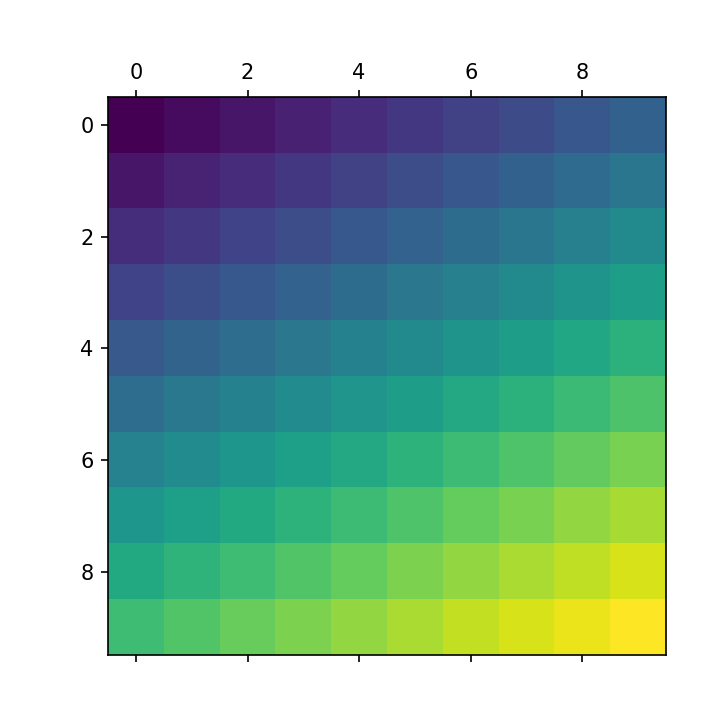

In [25]:
def sigm2d(x,y):
    return 1. / (1. + np.exp(-x*0.2 + -y*0.41))
x = np.linspace(-2,2,10)
y = np.linspace(-2,2,10)
x,y = np.meshgrid(x,y)
z = sigm2d(x.reshape(-1),y.reshape(-1))
z = z.reshape(10,10)
plt.matshow(z)